In [1]:
import numpy as np
import random
import networkx as nx
from collections import defaultdict
import time
from tqdm.notebook import tqdm
import ctypes

%matplotlib notebook
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Генераторы графов

In [2]:
# функция возвращает случайный простой граф в моделе Gnp 
# вероятность ребра p = 2*m/(n*(n-1)), чтобы среденее число ребер было = m
# структура хранения - список смежности, реализованный через словарь (хеш-таблица) списков 
# ребра представляют собой tuple двух вершин
def get_random_simple_Gnp_graph(n, m, seed=42):
  edge_p = 2*m/(n*(n-1))
  g = nx.random_graphs.fast_gnp_random_graph(n,edge_p,seed)
  
  return nx.convert.to_dict_of_lists(g)

In [3]:
# функция возвращает случайный ориентированный граф в моделе Gnp 
# вероятность ребра p = m/(n*(n-1)), чтобы среденее число ребер было = m
# структура хранения - список смежности, реализованный через словарь (хеш-таблица) списков 
# ребра представляют собой tuple двух вершин
def get_random_Gnp_digraph(n, m, seed=42):
  edge_p = m/(n*(n-1))
  g = nx.random_graphs.fast_gnp_random_graph(n,edge_p,seed,True)
  
  return nx.convert.to_dict_of_lists(g)

In [4]:
# функция возвращает случайный простой граф в моделе Gnm 
# структура хранения - список смежности, реализованный через словарь (хеш-таблица) списков 
# ребра представляют собой tuple двух вершин
def get_random_simple_Gnm_graph(n, m, seed=42):
  g = nx.random_graphs.gnm_random_graph(n,m,seed)

  return nx.convert.to_dict_of_lists(g)

In [5]:
# функция возвращает случайный ориентированный граф в моделе Gnm
# структура хранения - список смежности, реализованный через словарь (хеш-таблица) списков 
# ребра представляют собой tuple двух вершин
def get_random_Gnm_digraph(n, m, seed=42):
  g = nx.random_graphs.gnm_random_graph(n,m,seed,True)

  return nx.convert.to_dict_of_lists(g)

In [6]:
# функция возвращает связный ориентированный Ейлеров граф
# в графе n вершин, k - параметр, от которого зависти генерация
# структура хранения - список смежности, реализованный через словарь (хеш-таблица) списков 
# ребра представляют собой tuple двух вершин
def get_Euler_digraph(n, k=8):
  in_degs, out_degs = [k]*n, [k]*n 
  G = nx.generators.directed_havel_hakimi_graph(in_degs, out_degs)
  WCCs = list(nx.algorithms.components.weakly_connected_components(G))
  if len(WCCs) > 1:
    connecting_nodes = []
    for WCC in WCCs:
      some_vertex_of_WCC = next(iter(WCC))
      connecting_nodes.append(some_vertex_of_WCC)
    for i in range(1, len(connecting_nodes)):
      G.add_edge(connecting_nodes[i-1],connecting_nodes[i])
      G.add_edge(connecting_nodes[i],connecting_nodes[i-1])
    
  return nx.convert.to_dict_of_lists(G)

In [7]:
# утилитарная функция, переводящая таплы вида (1, 0, 0, 1)
# в числа, интерпетируя эту запись как число в двоичной записи
# эта функция нужна для следующей функции
def get_index_from_binary(tup):
  n = len(tup)
  mult = 1
  res = 0
  for i in range(n):
    res += tup[i]*mult
    mult *= 2
  return res

# функция возвращает связный ориентированный регулярный Ейлеров граф
# входные и выходные степени всех вершин совпадают и равны half_dim
# число вершин равно 4**half_dim
# структура хранения - список смежности, реализованный через словарь (хеш-таблица) списков 
# ребра представляют собой tuple двух вершин
def get_hypercube_digraph(half_dim):
  G = nx.generators.hypercube_graph(half_dim*2)
  directed_G = nx.DiGraph()
  Euler_circuit_G = nx.algorithms.eulerian_circuit(G)
  for (u,v) in Euler_circuit_G:
    directed_G.add_edge(get_index_from_binary(u), get_index_from_binary(v))
  return nx.convert.to_dict_of_lists(directed_G)

# Алгоритмы сортировки

# Алгоритмы для поиска мостов

In [8]:
import numpy as np
import sys

sys.setrecursionlimit(100000)


class ComputeBridgesDeterm:
    def __init__(self, adj_list):
        # init statistics
        self.timer = 0
        self.adj_list = adj_list
        self.history, self.bridges = [], []
        # determ bridges
        self.colors = ["white" for i in self.adj_list]
        self.ret = [np.inf for i in self.adj_list]
        self.entry = [0 for i in self.adj_list]
        # if node's color == white run dfs
        for i in self.adj_list:
            if self.colors[i] == "white":
                self.bridges_determ_dfs(i)

    def bridges_determ_dfs(self, vertex):
        # update color and timers
        self.colors[vertex] = "gray"
        self.history.append(vertex)
        self.timer += 1
        self.entry[vertex] = self.timer
        # for all neighbors: if adj_color == white: run dfs;
        for adjacent in self.adj_list[vertex]:
            if self.colors[adjacent] == "white":
                self.bridges_determ_dfs(adjacent)
                # ret = min(vertex, adjacent)
                self.ret[vertex] = min(self.ret[vertex], self.ret[adjacent])
                if self.ret[adjacent] > self.entry[vertex]:
                    if vertex < adjacent:
                        self.bridges.append((vertex, adjacent))
                    else:
                        self.bridges.append((adjacent, vertex))
            elif len(self.history) < 2 or self.history[-2] != adjacent:
                self.ret[vertex] = min(self.ret[vertex], self.entry[adjacent])
        self.colors[vertex] = "black"
        self.history.pop()


def compute_bridges_determ(adj_list):
    determ = ComputeBridgesDeterm(adj_list)
    return determ.bridges


class RandomBridges:
    def __init__(self):
        self.adj_list, self.samples = {}, {}
        self.bridges, self.edges, self.colors, self.history, = [], [], [], []
        self.EDGE_NUM = 0
        self.SAMPLE_NUM = 1

    def sampling_dfs(self, vertex):
        self.colors[vertex] = "gray"
        self.history.append(vertex)
        for adjacent in self.adj_list[vertex]:
            if self.colors[adjacent] == "white":
                self.sampling_dfs(adjacent)
            elif len(self.history) < 2 or self.history[-2] != adjacent:
                rand = np.uint64(
                    np.random.randint(0, np.iinfo(np.uint64).max, dtype=np.uint64)
                )
                self.samples[vertex][adjacent] = rand
                self.samples[adjacent][vertex] = rand
        self.colors[vertex] = "black"
        self.history.pop()

        if len(self.history) > 0:
            parent = self.history[-1]
            parent_edge_weight = np.uint64(0)
            for adjacent in self.adj_list[vertex]:
                if adjacent != parent:
                    parent_edge_weight ^= self.samples[vertex][adjacent]
            self.samples[vertex][parent] = parent_edge_weight
            self.samples[parent][vertex] = parent_edge_weight

    def launch_sampling(self):
        self.colors = ["white" for i in self.adj_list]
        for vertex in self.adj_list:
            if self.colors[vertex] == "white":
                self.sampling_dfs(vertex)

    def find_bridges(self, adj_list):
        self.adj_list = adj_list
        for i in range(len(adj_list)):
            self.samples[i] = {}
        self.launch_sampling()
        for first_key in self.adj_list:
            for second_key in self.adj_list[first_key]:
                if (second_key, first_key) not in self.bridges and self.samples[
                    first_key
                ][second_key] == 0:
                    self.bridges.append((first_key, second_key))
        return self.bridges

    def find_2bridges(self, adj_list, sort_fun):
        self.adj_list = adj_list
        for i in range(len(adj_list)):
            self.samples[i] = {}
        self.launch_sampling()
        for first_key in self.adj_list:
            for second_key in self.adj_list[first_key]:
                if (second_key, first_key) not in [
                    edge[self.EDGE_NUM] for edge in self.edges
                ]:
                    self.edges.append(
                        [(first_key, second_key), self.samples[first_key][second_key]]
                    )
        samples_list = [edge[self.SAMPLE_NUM] for edge in self.edges]
        sorted_args = sort_fun(samples_list)
        cluster_size = 0
        current_cluster = 0
        for i in range(len(sorted_args) - 1):
            cluster_size += 1
            if (
                self.edges[sorted_args[i]][self.SAMPLE_NUM]
                != self.edges[sorted_args[i + 1]][self.SAMPLE_NUM]
            ):
                if cluster_size > 1:
                    self.bridges.append([])
                    j = i - cluster_size + 1
                    while j < i:
                        self.bridges[current_cluster].append(
                            (self.edges[sorted_args[j]][self.EDGE_NUM])
                        )
                        j += 1
                    cluster_size = 0
                    current_cluster += 1
        return self.bridges


def compute_bridges_rand(adj_list):
    rand = RandomBridges()
    return rand.find_bridges(adj_list)


def compute_2bridges_rand(adj_list, sort_fun):
    rand = RandomBridges()
    return rand.find_2bridges(adj_list, sort_fun)

# Эйлеровы циклы

# Арифметика в конечных кольцах и полях

# Графики

In [9]:
def check_time(f, *args):
  start = time.time()
  f(*args)
  return time.time() - start

In [13]:
def plot_bridges(m_fun, start = 1000, step = 1000, end = 10001, number_of_retryes = 2):
  _x, determ_Gnp_y, determ_Gnm_y, rand_Gnp_y, rand_Gnm_y = [], [], [], [], []
  for n in tqdm(range(start,end,step)):
    m = m_fun(n)
    time_Gnp_determ = 0.
    time_Gnp_rand = 0.
    time_Gnm_determ = 0.
    time_Gnm_rand = 0.
    for exp_num in range(number_of_retryes):
      g = get_random_simple_Gnp_graph(n,m,exp_num)
      time_Gnp_determ += check_time(compute_bridges_determ, g)
      time_Gnp_rand += check_time(compute_bridges_rand, g)
      g = get_random_simple_Gnm_graph(n,m,exp_num)
      time_Gnm_determ += check_time(compute_bridges_determ, g)
      time_Gnm_rand += check_time(compute_bridges_rand, g)
    time_Gnp_determ /= number_of_retryes
    time_Gnp_rand /= number_of_retryes
    time_Gnm_determ /= number_of_retryes
    time_Gnm_rand /= number_of_retryes
    _x.append(n)
    determ_Gnp_y.append(time_Gnp_determ)
    rand_Gnp_y.append(time_Gnp_rand)
    determ_Gnm_y.append(time_Gnm_determ)
    rand_Gnm_y.append(time_Gnm_rand)

  plt.plot(_x, determ_Gnp_y, label = "determ Gnp")
  plt.plot(_x, rand_Gnp_y, label = "rand Gnp")
  plt.plot(_x, determ_Gnm_y, label = "determ Gnm")
  plt.plot(_x, rand_Gnm_y, label = "rand Gnm")
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
  plt.xlabel('number of vertices')
  plt.ylabel('time s.')
  plt.title(f"Эксперименты с мостами, start: {start}, step: {step}, end: {end},\n \
  number of retryes: {number_of_retryes}, edges density: {n/m}")
  #plt.figure(figsize= (1000,1000))
  plt.show()

### Bridges

  0%|          | 0/10 [00:00<?, ?it/s]

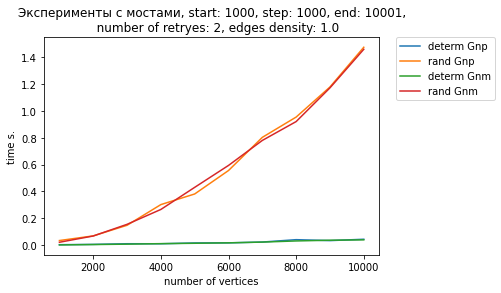

Total time: 27.175405025482178


  0%|          | 0/10 [00:00<?, ?it/s]

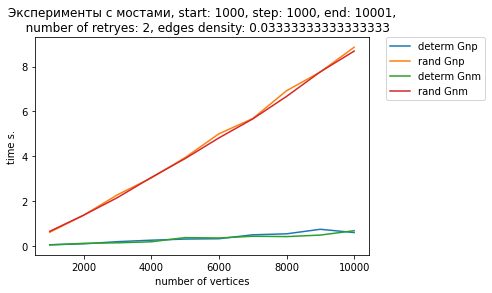

Total time: 230.83269095420837


  0%|          | 0/10 [00:00<?, ?it/s]

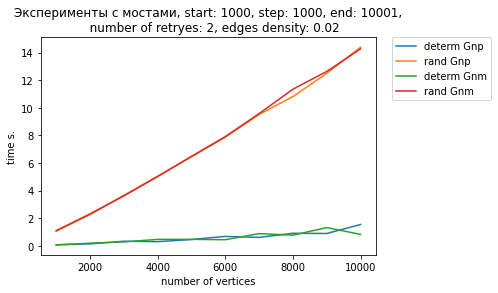

Total time: 378.15473079681396


In [16]:
print(f"Total time: {check_time(plot_bridges, lambda n: 1*n)}")
print(f"Total time: {check_time(plot_bridges, lambda n: 30*n)}")
print(f"Total time: {check_time(plot_bridges, lambda n: 50*n)}")

  0%|          | 0/10 [00:00<?, ?it/s]

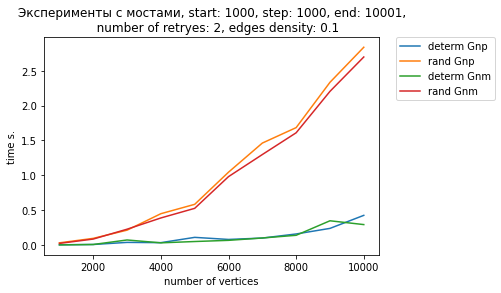

Total time: 55.95739459991455


  0%|          | 0/10 [00:00<?, ?it/s]

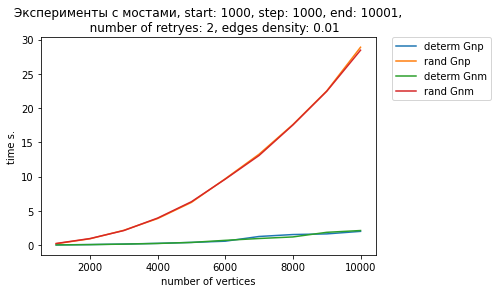

Total time: 531.1800680160522


  0%|          | 0/10 [00:00<?, ?it/s]

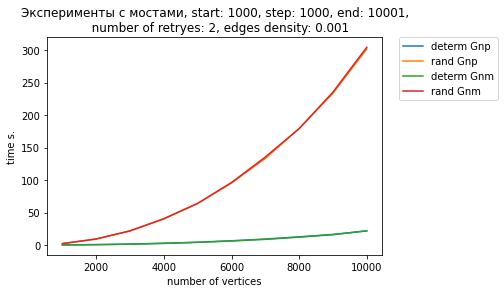

Total time: 5520.974536657333


In [17]:
print(f"Total time: {check_time(plot_bridges, lambda n: n**2/1000)}")
print(f"Total time: {check_time(plot_bridges, lambda n: n**2/100)}")
print(f"Total time: {check_time(plot_bridges, lambda n: n**2/10)}")